# Machine Learning - Classification

This module, we'll talk about another class of problems we can solve with machine learning. Classification is a subcategory of supervised learning where the goal is to predict the categorical class labels of new instances based on past observations.

Generally, there are 2 main types of classification problems:
- Binary: classifying  into 2 classes. (i.e., Spam and not-spam)
- Multi-class classification: classifying into multiple classes. (i.e., images of handwritten character recognition)

in it's simplest formats, the objective is to find a line or a plane that segregates the data points into different classes.
![simple classification](./assets/simple-classification.png)

In [1]:
# in this cell, we'll import all the libraries and packages we'll need in this tutorial.

# Python ≥3.10 is required
import sys
assert sys.version_info >= (3, 10)

# Common imports
import numpy as np
import pandas as pd
import os

# Scikit Learn imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("bmh")

# to make this notebook's output stable across runs
np.random.seed(42)

## Titanic Survival
In this tutorial we'll use the titanic dataset from [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/). We will use to train a model that classifies passengers based on whether or not they've survived. The objective would be to develop a model that would predict survival based on other features and attributes.

We'll start with importing the dataset from `data/titanic.csv`, and printing samples of the data.

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


We see that we have the following features, this info was provided on the [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/).

| Feature     | Description                                                                                             |
| ----------- | ------------------------------------------------------------------------------------------------------- |
| `pclass`    | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd). This can be considered as proxy for socio-economic status. |
| `survived`  | Survival (0 = No; 1 = Yes)                                                                              |
| `name`      | Name                                                                                                    |
| `sex`       | Sex                                                                                                     |
| `age`       | Age                                                                                                     |
| `sibsp`     | Number of Siblings/Spouses Aboard                                                                       |
| `parch`     | Number of Parents/Children Aboard                                                                       |
| `ticket`    | Ticket Number                                                                                           |
| `fare`      | Passenger Fare                                                                                          |
| `cabin`     | Cabin                                                                                                   |
| `embarked`  | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)                                    |
| `boat`      | Lifeboat (if survived)                                                                                  |
| `body`      | Body number (if did not survive and body was recovered)                                                 |
| `home.dest` | Home/Destination                                                                                        |

## pre-EDA
Let's do some exploratory data analysis to get a better understanding of the data. 

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


let's visualize the histogram of the data to see the distribution of the data.

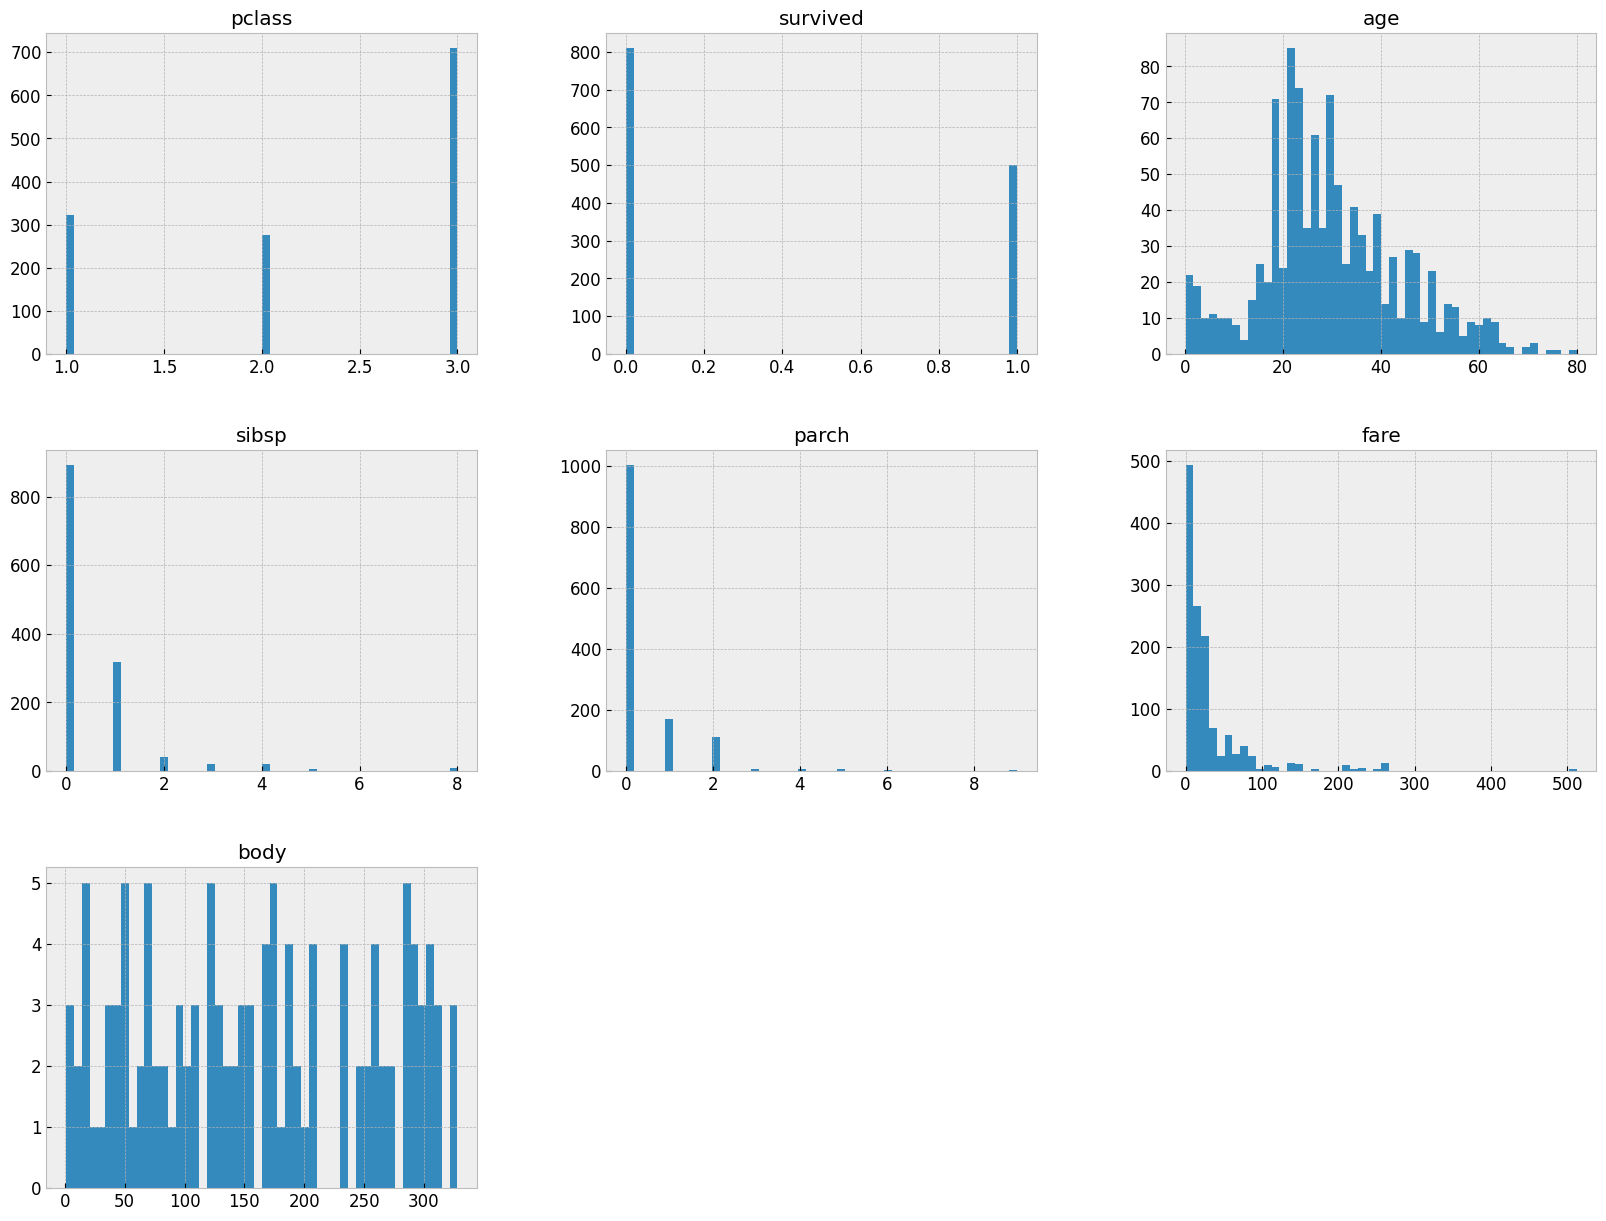

In [4]:
# REMEMBER: number of bins indicate the number if intervals we want to divide our data into
titanic.hist(bins=50, figsize=(20,15))
plt.show()

> 🦉 **Note**: Take a moment and try to make some observations based on the above before you continue reading the below.

We can observer the following:

- Most of the passengers were in the 3rd class.
- `survived` is the target variable, and we can see that most of the passengers did not survive.
- Majority of passengers were traveling alone (no siblings or spouses, no parents or children).
- There's a lot of missing data in the `cabin`, and `age` columns.
- `pclass`, `sex`, `embarked` are categorical variables.

| Column     | Type                                          | notes                                                                                                                                                                                                                                                                           |
| ---------- | --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| pclass     | categorical - ordinal                         |                                                                                                                                                                                                                                                                                 |
| name       | string - would this be valuable to our model? |                                                                                                                                                                                                                                                                                 |
| sex        | categorical - nominal                         |                                                                                                                                                                                                                                                                                 |
| age        | numerical - continuous                        | the reason why it's not discrete, is that we see the column type set to float64, and some of the values are 0.92 (less than a year old)                                                                                                                                         |
| sibsp      | numerical - discrete                          |                                                                                                                                                                                                                                                                                 |
| parch      | numerical - discrete                          |                                                                                                                                                                                                                                                                                 |
| ticket     | string - would this be valuable to our model? |                                                                                                                                                                                                                                                                                 |
| fare       | numerical - continuous                        |                                                                                                                                                                                                                                                                                 |
| cabin      | _(Quiz Question)_                             |                                                                                                                                                                                                                                                                                 |
| embarked   | Categorical - could be ordinal or nominal     | if it's just a matter of location, then it's nominal, however, if you take into account that the titanic boarded in Southampton, and then sailed to Cherbourg, and then to Queenstown, then it's ordinal. Do we think people who boarded first, had better chances of survival? |
| boat       | string                                        | boat identifier                                                                                                                                                                                                                                                                 |
| body       | numerical (or string)                         | body ID                                                                                                                                                                                                                                                                         |
| home. dest |                                               |                                                                                                                                                                                                                                                                                 |
| survived   | category _(ordinal, or nominal?)_             |                                                                                                                                                                                                                                                                                 |

- we also realize that both `boat` and `body` are what we call **Leaky Features**. These are features that kind of gives the answer about the future. Having a `body` number, means they didn't survive. These are features that are not available at the time of prediction, and therefore should not be used in the model. We'll drop these features later on.


**how about missing values?**

In [5]:
titanic.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

We will need to impute the missing values in the Age column.

**BUT** we shouldn't do any of that until the data is split into training and test sets. We don't want to introduce any bias into the data.

Let me show another interesting library called `pandas_profiling`. This library will generate a report of the data, and it's very useful for exploratory data analysis.

if you don't already have it installed, you can install it with `pipenv install pandas-profiling ipywidgets`.

In [6]:
import pandas_profiling
pandas_profiling.ProfileReport(titanic, title='Pandas Profiling Report')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The generated report is able, to a high degree of correctness, to detect the data types of the columns, and also detect missing values.
It's able to show the distribution of the data, and also the correlation between the features.

Before we proceed any further, and before we start cleaning, the data, dropping columns, or anything else, we need to split the data into training and test sets.

____________________

## Data Splitting